#### Content of this ipy notebook:
* Part 1 - Data Preprocessing and Feature Engineering
* Part 2 - Models and Predictions
    * 2.1 LGBM *(refer: lgbm.ipynb)*
    * 2.2 Back to Xgboost
    * 2.3 Xgboost - feature selection with correlation
    * 2.4 Ensembling *(refer: ensemble.ipynb)*
    * 2.5 其他嘗試 *(refer: lag_max3_withcorr41.ipynb & ensemble.ipynb)*
* 心得

# Part 1 - Data Preprocessing and Feature Engineering

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)

In [2]:
items = pd.read_csv('./input/items.csv')
shops = pd.read_csv('./input/shops.csv')
cats = pd.read_csv('./input/item_categories.csv')
train = pd.read_csv('./input/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('./input/test.csv').set_index('ID')

In [4]:
train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


對各dataframe(包括train、test、items、shops、cats)，印出其各column之相異值個數。

In [15]:
# count of distinct elements in each column of each dataframe
print("train:")
print(train.nunique())
print("\ntest:")
print(test.nunique())
print("\nitems:")
print(items.nunique())
print("\nshops:")
print(shops.nunique())
print("\ncats:")
print(cats.nunique())

train:
date               1034
date_block_num       34
shop_id              57
item_id           21806
item_price        19990
item_cnt_day        197
dtype: int64

test:
shop_id      42
item_id    5100
dtype: int64

items:
item_name           22170
item_id             22170
item_category_id       84
dtype: int64

shops:
shop_name    60
shop_id      60
dtype: int64

cats:
item_category_name    84
item_category_id      84
dtype: int64


## Outliers (of price and item_cnt_day)

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).

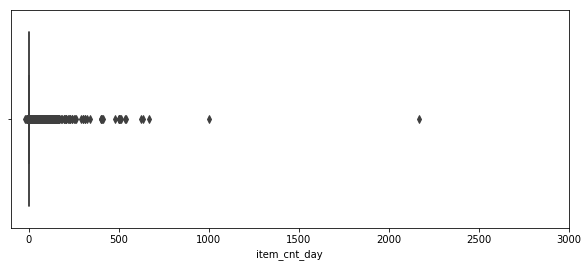

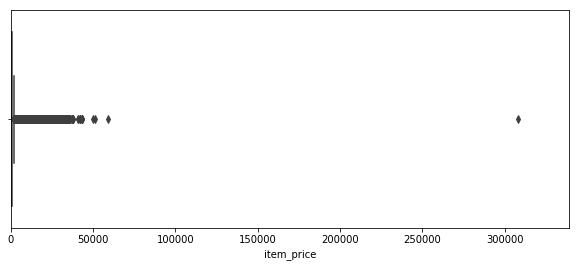

In [5]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [6]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

There is one item with price below zero. Fill it with median.

In [7]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

Several shops are duplicates of each other (according to its name). Fix train and test set.

In [8]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Shops/Cats/Items preprocessing
Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [7]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0]) #
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

## Monthly sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. 

In [8]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)) )), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

#### 以下建立一dataframe：matrix，它將用來記錄「某個月中，某家店的某個item」的資訊。  
也是因為我們最後要預測的是**monthly amount** of item_cnt_day.

In [9]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34): # total 34 months in the training data
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

14.48514723777771

In [10]:
print(matrix.shape)
matrix.head(2)

(10913804, 3)


,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27


在train中加入"revenue"，表該天裡該項產品所帶來的收入。它在後面的trend feature部分會用到。

In [11]:
train['revenue'] = train['item_price'] * train['item_cnt_day']

將item_cnt_month加到matrix中。    
p.s. dataframe.groupby().agg()就如同relational database中relational algebra中的aggregate function  
p.s. pandas中的merge和relational database的join很像。

In [12]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

6.642135143280029

In [13]:
print(matrix.shape)
matrix.head(2)

(10913804, 4)


,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0


## Test set
Append test pairs to the matrix.

In [14]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

在matrix中加入test相對應的rows，即「第34個月，某家店，某個item」

In [15]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.1405172348022461

In [16]:
print(matrix.shape)
matrix.head(2)

(11128004, 4)


,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0


## Merge Shops/Items/Cats features

以merge的方式在matrix中加入["city_code", "item_category_id", "type_code", "subtype_code"]

In [17]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left') # has the ['city_code']
matrix = pd.merge(matrix, items, on=['item_id'], how='left') # has the ['item_category_id']
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left') # has the ['type_code','subtye_code']
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

5.83989405632019

In [18]:
matrix.head(2)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,4
1,0,2,27,1.0,0,19,5,10


## Traget lags

lag_feature(df, lags, col)：在df中加入之於col的lag columns  
(關鍵步驟：在date_block_num上做shift)

In [19]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i # forward the values of previous months (join with the later month below)
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

Add lag features of 'item_cnt_month'

In [20]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

45.57046031951904

In [21]:
matrix.head(2)

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN


## Mean encoded features

以下在matrix中加入許多lag columns，加入的各columns在建立時，其aggregate function都是先matrix.groupby某一些column，再做.agg({'item_cnt_month': ['mean']})：  
* .groupby(['date_block_num'])  
* .groupby(['date_block_num', 'item_id'])，其lag取[1,2,3,6,12]  
* .groupby(['date_block_num', 'shop_id'])，其lag取[1,2,3,6,12]  
* .groupby(['date_block_num', 'item_category_id'])  
* .groupby(['date_block_num', 'shop_id', 'item_category_id'])  
* .groupby(['date_block_num', 'shop_id', 'type_code'])  
* .groupby(['date_block_num', 'shop_id', 'subtype_code'])  
* .groupby(['date_block_num', 'city_code'])  
* .groupby(['date_block_num', 'item_id', 'city_code'])  
* .groupby(['date_block_num', 'type_code'])  
* .groupby(['date_block_num', 'subtype_code'])  

In [22]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

15.960367918014526

In [23]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

49.705212354660034

In [24]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

54.15058708190918

In [25]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

17.607969760894775

In [26]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

22.324707746505737

In [27]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

22.027258157730103

In [28]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

23.844428062438965

In [29]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

22.39388370513916

In [30]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

31.422506093978882

In [31]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

20.48703098297119

In [32]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

22.29037117958069

## Trend features

Price trend for the last six months.  

In [33]:
ts = time.time()

# 某item在所有train月下的平均價格
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

# 某item在某個月的平均價格
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

# 「某item在某個月（lag1~lag6）的平均價格」相對於「某item在所有train月下的平均價格」
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

# me: return the first non-0 lag value of the row (check from _1 to _6)
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
# me: the ['delta_price_lag'] of each row is the first non-0 'delta_price_lag_ 
# (check from the last month to the last sizth month)
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

493.22503304481506

Last month shop revenue trend  

In [34]:
ts = time.time()

# 某個月下，某店，收入多少
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

# 某家店，平均月收入多少
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

# 「某個月下，某家店的收入」相對於「該家店的平均月收入」
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

# me: does not use something like select_trend(), 
# I think it's because 'delta_revenue' are all non-0
matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

25.4444899559021

## Special features  

In [35]:
# 月份
matrix['month'] = matrix['date_block_num'] % 12

In [36]:
# 該月天數
# 以Series.map()的方式，創建一個值有對應關係的新的series
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

#Months **since the last** sale for each shop/item pair.  
Recording the cycle of the buying of each item in each store.  
<i>Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.</i>  

In [37]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

2211.7938210964203

#Months **since the last** sale for each item.  
Record the cycle of the buying of each item (all store).

In [38]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num > last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

1466.9659650325775

#Months **since the first** sale for each shop/item pairs.  
#Months **since the first** sale for each item.

In [39]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

3.245944023132324

## Final preparations
Because our max lag value is 12, drop the first 12 months.  

In [40]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

1.9117240905761719

Producing lags brings a lot of nulls. (原因如：前一個月和目前這一個月，陳列出的產品會有不同）

In [41]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col): # me: exclude 'delta_price_lag'
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

6.580653190612793

In [42]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

In [43]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 40 columns):
date_block_num                          int8
shop_id                                 int8
item_id                                 int16
item_cnt_month                          float16
city_code                               int8
item_category_id                        int8
type_code                               int8
subtype_code                            int8
item_cnt_month_lag_1                    float16
item_cnt_month_lag_2                    float16
item_cnt_month_lag_3                    float16
item_cnt_month_lag_6                    float16
item_cnt_month_lag_12                   float16
date_avg_item_cnt_lag_1                 float16
date_item_avg_item_cnt_lag_1            float16
date_item_avg_item_cnt_lag_2            float16
date_item_avg_item_cnt_lag_3            float16
date_item_avg_item_cnt_lag_6            float16
date_item_avg_item_cnt_lag_12       

In [44]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# Part 2, Models and Predictions

#### 2.1 LGBM (refer: lgbm.ipynb)
由於這種tabular data的情況
以GBT為目前來說相當有效的方法，因此除了Xgboost外，我簡單試了LGBM，其速度明顯快於Xgboost。

#### 2.2 Back to Xgboost  
* 由於LGBM在public leaderboard上效果不佳，因此決定還是從原本此kernel使用的Xgboost下手。  
* 我在此將所有原作者創造的Mean Encode Feature都comment掉，一方面是因為原先我理解錯誤，以為作者將target當成X了; 另一方面也覺得可以從最基本的幾個feature做起，以簡單為原則。
* 跑出的結果竟然比原kernel的public score更好。
* 以下探討Xgboost的feature selection的必要性：
    * 本以為Xgboost自己會做特徵選擇，因此我們不太需要先做。
    * 經過特徵篩選後，無論如何可以提升performance
    * xgboost或者说每棵树在选择分叉点的时候，都是以**贪婪的方式**选择局部最优，所以有些特征可能在局部不错，但是从整体上看降低了模型整体的精度。

In [5]:
data = pd.read_pickle('data.pkl')

In [6]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
#     'date_avg_item_cnt_lag_1',
#     'date_item_avg_item_cnt_lag_1',
#     'date_item_avg_item_cnt_lag_2',
#     'date_item_avg_item_cnt_lag_3',
#     'date_item_avg_item_cnt_lag_6',
#     'date_item_avg_item_cnt_lag_12',
#     'date_shop_avg_item_cnt_lag_1',
#     'date_shop_avg_item_cnt_lag_2',
#     'date_shop_avg_item_cnt_lag_3',
#     'date_shop_avg_item_cnt_lag_6',
#     'date_shop_avg_item_cnt_lag_12',
#     'date_cat_avg_item_cnt_lag_1',
#     'date_shop_cat_avg_item_cnt_lag_1',
# #     'date_shop_type_avg_item_cnt_lag_1', # he cmt
# #     'date_shop_subtype_avg_item_cnt_lag_1', # he cmt
#     'date_city_avg_item_cnt_lag_1',
#     'date_item_city_avg_item_cnt_lag_1',
# #     'date_type_avg_item_cnt_lag_1', # he cmt
# #     'date_subtype_avg_item_cnt_lag_1', # he cmt
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [7]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [8]:
X_train.drop(["date_block_num"], axis=1, inplace=True)
X_valid.drop(["date_block_num"], axis=1, inplace=True)
X_test.drop(["date_block_num"], axis=1, inplace=True)

In [9]:
del data
gc.collect();

In [10]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    nthread=4,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

/Users/juichang/py_36_env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/juichang/py_36_env/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:1.15906	validation_1-rmse:1.1191
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10573	validation_1-rmse:1.08238
[2]	validation_0-rmse:1.06584	validation_1-rmse:1.05337
[3]	validation_0-rmse:1.03843	validation_1-rmse:1.03052
[4]	validation_0-rmse:1.012	validation_1-rmse:1.0091
[5]	validation_0-rmse:0.989207	validation_1-rmse:0.993597
[6]	validation_0-rmse:0.964787	validation_1-rmse:0.977584
[7]	validation_0-rmse:0.94428	validation_1-rmse:0.965237
[8]	validation_0-rmse:0.92879	validation_1-rmse:0.954564
[9]	validation_0-rmse:0.916179	validation_1-rmse:0.946154
[10]	validation_0-rmse:0.903382	validation_1-rmse:0.938717
[11]	validation_0-rmse:0.893141	validation_1-rmse:0.933824
[12]	validation_0-rmse:0.885597	validation_1-rmse:0.929325
[13]	validation_0-rmse:0.878841	validation_1-rmse:0.925104
[14]	validation_0-rmse:0.87249	validation

2171.0383670330048

In [11]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submissionrmdate_bla_cnt.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_trainrmdate_bla_cnt.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_testrmdate_bla_cnt.pickle', 'wb'))

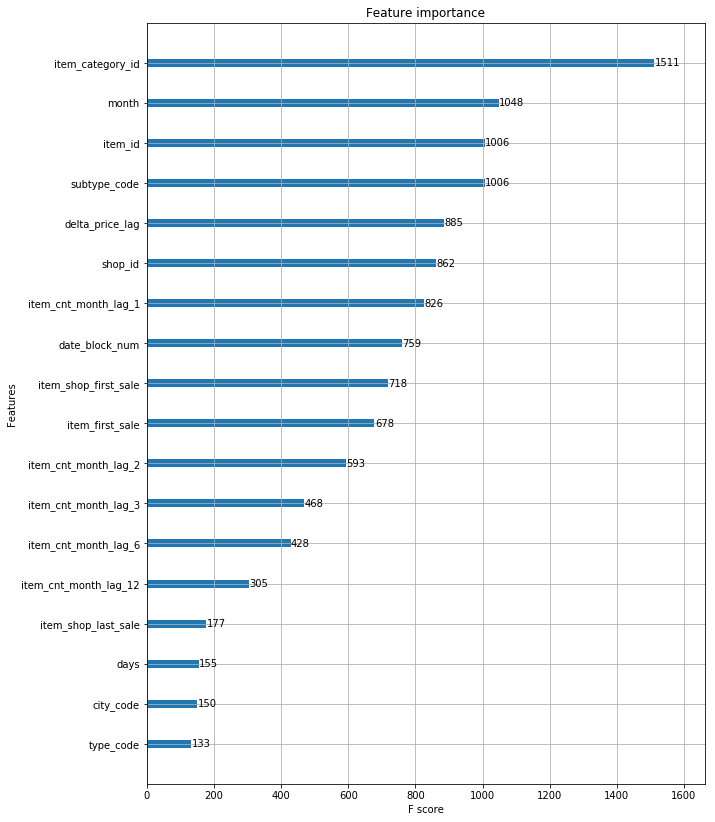

In [75]:
plot_features(model, (10,14))

#### 2.3 Xgboost (feature selection with correlation)  

In [5]:
data = pd.read_pickle('data.pkl')

In [43]:
ts = time.time()
y_corr = data.corr()['item_cnt_month']
time.time() - ts

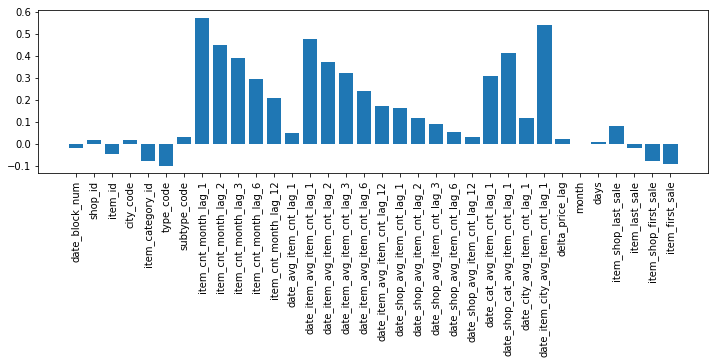

In [56]:
if "item_cnt_month" in y_corr.index:
    y_corr.drop("item_cnt_month", inplace=True)
    
plt.figure(figsize=(12,3))
plt.bar(y_corr.index, y_corr)
plt.xticks(rotation=90)
plt.show()

根據上圖篩選掉一些feature:

In [6]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
#     'city_code',
    'item_category_id',
    'type_code',
#     'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
#     'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
#     'date_shop_avg_item_cnt_lag_6',
#     'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
#     'date_shop_type_avg_item_cnt_lag_1', # he cmt
#     'date_shop_subtype_avg_item_cnt_lag_1', # he cmt
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
#     'date_type_avg_item_cnt_lag_1', # he cmt
#     'date_subtype_avg_item_cnt_lag_1', # he cmt
#     'delta_price_lag',
    'month',
#     'days',
    'item_shop_last_sale',
#     'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [7]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [8]:
X_train.drop(["date_block_num"], axis=1, inplace=True)
X_valid.drop(["date_block_num"], axis=1, inplace=True)
X_test.drop(["date_block_num"], axis=1, inplace=True)

In [9]:
del data
gc.collect();

In [10]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    nthread=4,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=41)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

/Users/juichang/py_36_env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/juichang/py_36_env/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:1.15906	validation_1-rmse:1.1191
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.10573	validation_1-rmse:1.08238
[2]	validation_0-rmse:1.06584	validation_1-rmse:1.05337
[3]	validation_0-rmse:1.03843	validation_1-rmse:1.03052
[4]	validation_0-rmse:1.012	validation_1-rmse:1.0091
[5]	validation_0-rmse:0.989207	validation_1-rmse:0.993597
[6]	validation_0-rmse:0.964787	validation_1-rmse:0.977584
[7]	validation_0-rmse:0.94428	validation_1-rmse:0.965237
[8]	validation_0-rmse:0.92879	validation_1-rmse:0.954564
[9]	validation_0-rmse:0.916179	validation_1-rmse:0.946154
[10]	validation_0-rmse:0.903382	validation_1-rmse:0.938717
[11]	validation_0-rmse:0.893141	validation_1-rmse:0.933824
[12]	validation_0-rmse:0.885597	validation_1-rmse:0.929325
[13]	validation_0-rmse:0.878841	validation_1-rmse:0.925104
[14]	validation_0-rmse:0.87249	validation

2171.0383670330048

In [11]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('./output/xgb_sub_corr41.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('./output/xgb_train_corr41.pickle', 'wb'))
pickle.dump(Y_test, open('./output/xgb_test_corr41.pickle', 'wb'))

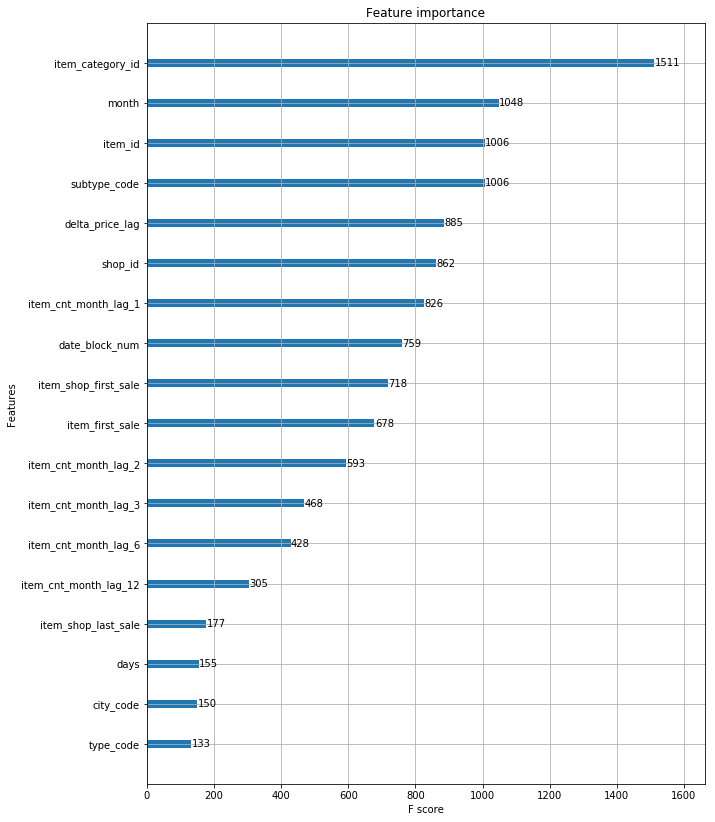

In [75]:
plot_features(model, (10,14))

#### 2.4 Ensembling (refer: ensemble.ipynb)
由於LGBM的效果明顯差於另兩個Xgboost做出的結果，因此即便兩prediction都是出自同一種model，還是決定ensemble看看，嘗試「同種model，不同feature」的ensemble能做出多少進步。最後得出我最好的public score:0.90104

#### 2.5 其他嘗試 (refer: lag_max3_withcorr41.ipynb & ensemble.ipynb)
##### 2.5.1 Lag Max 3
由於原kernel取lag最大取到12個月，這樣必須捨棄前12月而損失了很多training data, 於是我嘗試只取到前3個月。然而public score只有0.93303。  
##### 2.5.2 Ensemble models with diffenent training seed only
因為我發現同為XGBRegreesor，只變seed值竟也會造成不少的public score的差距，因此我有測試「只改變seed值做了三次XGB，將它們做ensemble」。然而效果不好（score值大概也是個別score值的加起來平均），可見在只改變seed的情況下做訓練，model的prediction還是會有類似的傾向（也就是其共變異數應該較接近1）

### 心得
目前體會到**time series prediction**的一大難處是**validation不易反映test set**，因為時間本身就是一項重要的變因。以本project為例：我們要預測的是2015年11月的資料，我曾考慮是否採用2013與2014年11月的資料，但後來仍覺得2015/10的資料應該還是與2015/11更類似，因為相同月份的相似性應不足以彌補1年的時間帶來的變化。即使kernel作者合理的選擇了validation，但在做這次project的過程中仍可明顯體會到validation loss與不能有效反應public score（如val loss = 0.89X的public score不比0.95X者）